All libraries loaded
Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step - loss: 1.1498
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0642
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9832
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9056
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8307
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7578
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6865
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6166
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5482
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4819
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4187
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3604
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3097
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2696
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2437
Epoch 16/100
1/1 ━━━━━━━━━━━━━━

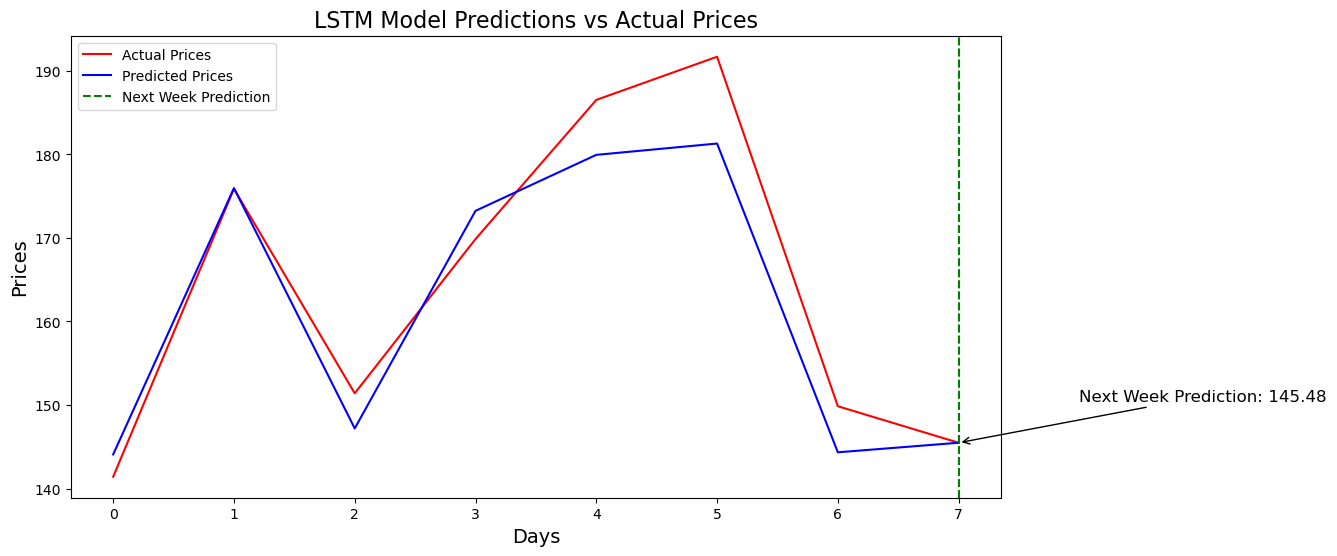

In [69]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")

# Normalizer class definition
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        x = np.array(x)  # Ensure x is a numpy array
        self.mu = np.mean(x, axis=0, keepdims=True)
        self.sd = np.std(x, axis=0, keepdims=True)
        normalized_x = (x - self.mu) / self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu


# Load stock price time series data as already done in your code
stock = "GOOG"  # Replace with your stock name
df_stock = pd.read_csv(f'/Users/sunithakosireddy/Downloads/data/{stock}_weekly_adjusted.csv', header=0, index_col=0, parse_dates=[0], thousands=',')
df_earnings = pd.read_csv(f'/Users/sunithakosireddy/Downloads/data/{stock}_earnings.csv', header=0, index_col=0, parse_dates=[0], thousands=',')
df_insider = pd.read_csv(f'/Users/sunithakosireddy/Downloads/data/{stock}_insider_transactions.csv', header=0, index_col=0, parse_dates=[0], thousands=',')

# Extract and combine data
closing_prices = df_stock['Adjusted Close'].values
surprise_percentage = df_earnings['surprisePercentage'].values
insider_transactions = df_insider['Shares'].values  

min_length = min(len(closing_prices), len(surprise_percentage), len(insider_transactions))
combined_data = np.column_stack((closing_prices[:min_length], 
                                  surprise_percentage[:min_length], 
                                  insider_transactions[:min_length]))

# Normalize data
normalizer = Normalizer()
combined_data_scaled = normalizer.fit_transform(combined_data)

# Create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_dataset(combined_data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, batch_size=32, epochs=100)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform to get the original scale for predicted prices
predictions = normalizer.inverse_transform(np.column_stack((predictions, np.zeros(predictions.shape), np.zeros(predictions.shape))))[:, 0]
y_test_scaled = normalizer.inverse_transform(np.column_stack((y_test.reshape(-1, 1), np.zeros(y_test.shape), np.zeros(y_test.shape))))[:, 0]

# Predicting the next week's stock price
last_sequence = combined_data_scaled[-time_step:]  # Get the last sequence of the scaled data
last_sequence = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))  # Reshape for model input
next_week_prediction = model.predict(last_sequence)

# Inverse transform to get the original price scale
next_week_price = normalizer.inverse_transform(np.column_stack((next_week_prediction, np.zeros(next_week_prediction.shape), np.zeros(next_week_prediction.shape))))[:, 0]

# Prepare for plotting
predictions = np.append(predictions, next_week_price)  # Append next week's prediction
y_test_scaled = np.append(y_test_scaled, next_week_price)  # Include last true price for consistency

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_test_scaled)), y_test_scaled, label='Actual Prices', color='red')
plt.plot(np.arange(len(predictions)), predictions, label='Predicted Prices', color='blue')
plt.axvline(x=len(y_test_scaled) - 1, color='green', linestyle='--', label='Next Week Prediction')  # Line for next week
plt.title('LSTM Model Predictions vs Actual Prices', fontsize=16)
plt.xlabel('Days', fontsize=14)

plt.ylabel('Prices', fontsize=14)
plt.legend()
plt.title('LSTM Model Predictions vs Actual Prices', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.axvline(x=len(y_test_scaled) - 1, color='green', linestyle='--', label='Next Week Prediction')  # Line for next week
plt.annotate(f'Next Week Prediction: {next_week_price[0]:.2f}', 
             xy=(len(y_test_scaled) - 1, next_week_price[0]), 
             xytext=(len(y_test_scaled), next_week_price[0] + 5), 
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12)

plt.show()